# Summary
This notebook walks through the Cagniard de Hoop integral method and l1 mode summmation method. 

In [40]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from __future__ import print_function
import obspy
%matplotlib inline

## Cagniard de Hoop Method
### Time functions
The Cagniard de Hoop method is a calculation over individual rays. For each ray, we must find the path through the complex p-plane for which time is real and increasing. To facilitate this, we define a time function for each geometric ray. A direct wave has the familiar formula $t = px + \eta z$, while more complicated waves have functions of the form $t = px + \eta_i z_i$. Since $\eta = \sqrt{B^{-2}-p^2}$, it wasn't obvious how to do a MATLAB-style element-wise caluculation over an array of p-points. Instead, individual functions that take one p-point and return one t-point are defined.

The time functions are labeled as upgoing [**u**] or downgoing [**d**] from the source followed by reflections [**R**] and transmissions [**T**] at each layer interface encountered. Each function calculates the time associated with a point in the complex p-plane. The inputs are a [p] value, the horizontal source-receiver distance [x], the depths of layer interfaces [z_array], and the velocities of the layers [B_array]. The velocity structure is assumed to take the form

z_array[0] --------------  
velocity: B_array[0]  
z_array[1] --------------  
velocity: B_array[1]  

        ...  

z_array[n] --------------  
velocity: B_array[n] (this is the half-space)

For three layers over a half-space with the source in the second layer, the first five rays of interest are the direct transmission, two reflected multiples, the simplest upgoing wave which traverses the third layer, and the simplest downgoing wave which traverses the third layer. Their time functions are defined:

In [41]:
def time_func_uT(p_point,x,z_array,B_array):
    return p_point*x + (z_array[0]-z_array[1])*np.sqrt(1/B_array[1]**2-p_point**2) + z_array[1]*np.sqrt(1/B_array[0]**2-p_point**2)
def time_func_uTRR(p_point,x,z_array,B_array):
    return p_point*x + (z_array[0]-z_array[1])*np.sqrt(1/B_array[1]**2-p_point**2) + 3*z_array[1]*np.sqrt(1/B_array[0]**2-p_point**2)
def time_func_uTRRRR(p_point,x,z_array,B_array):
    return p_point*x + (z_array[0]-z_array[1])*np.sqrt(1/B_array[1]**2-p_point**2) + 5*z_array[1]*np.sqrt(1/B_array[0]**2-p_point**2)
def time_func_dRT(p_point,x,z_array,B_array):
    return p_point*x + (2*z_array[2]-z_array[0]-z_array[1])*np.sqrt(1/B_array[1]**2-p_point**2) + z_array[1]*np.sqrt(1/B_array[0]**2-p_point**2)
def time_func_dTRTT(p_point,x,z_array,B_array):
    return p_point*x + 2*(z_array[3]-z_array[2])*np.sqrt(1/B_array[2]**2-p_point**2) + 2*(z_array[2]-z_array[1])*np.sqrt(1/B_array[1]**2-p_point**2) + z_array[1]*np.sqrt(1/B_array[0]**2-p_point**2)


### P-plane Path
To find the function $t(p)$ for each ray, we start from $p=0$ and use a radial search. The function goes out to infinite time, so we must choose a stop condition. Here, a maximum time is used. The path-finding function takes inputs for the horizontal distance [x], the depths of layer interfaces [z_array], the layer velocities [B_array], the time function for the ray of interest [time_func], and the maximum time to calculate [t_max].

In [42]:
def path_search_radial(x, z_array, B_array, time_func, t_max):
    p = [0*1j] #start at p=0
    t = [time_func(p[0],x,z_array,B_array).real] #find the first t value
    
    while t[-1] < t_max:
        # split the p-point into real and complex coordinates
        w0 = p[-1].real
        y0 = p[-1].imag
        coords = []
        # define the search space for the next point
        for theta in range(0,90):
            th = theta*np.pi/180
            w = w0 + np.cos(th)*.0005
            y = y0 + np.sin(th)*.0005
            coords.append((w,y))
        # calculate t values over the search space
        tvals = [time_func(complex(*coord),x,z_array,B_array) for coord in coords]
        # find the maximum real time point
        t_ind = np.argmax([tv.real for tv in tvals])
        t.append(tvals[t_ind].real)
        p.append(complex(*coords[t_ind]))
    
    return t, np.array(p)

### Find $dp/dt$
For each $t(p)$ path we also need to find the function $dp/dt$. The path finding function does not result in points that are evenly spaced in time, so we use an interpolator. The inputs to get $dp/dt$ are the path solution points in time [t_solution] and p-points [p_solution] and the required spacing in time [dt]. Note that the path actually begins on the negative real p axis, to the first point in the t solution (at p=0) should not have t=0. We add this part of the path here for a complete solution. ~~However, the value of dp/dt in this region should always be zero and dp/dt is always multiplied by p in the final solution, so we can set all p-values for this section to p=0 (since we can't interpolate beyond the range of the input function).~~ <-- This assumption is incorrect. The slope in the p-plane for the $p<0$ section of the path is zero, but that does not make dp/dt=0. I'm leaving it in for now because the first time point (p=0) is different for each ray, forcing them all to start at t=0 makes later calculations easier.

In [43]:
def get_dpdt(t_solution,p_solution,dt):
    f=interp1d(t_solution,p_solution)
    t_0 = np.ceil(t_solution[0]/dt)*dt #round t[0] up to nearest dt unit
    xi=np.arange(t_0,np.floor(t_solution[-1]),dt)
    yi = f(xi)
    dpdt = np.diff(yi)/dt
    stub = np.arange(0,t_0,dt) #interpolation points between t=0 and t_0
    dpdt = np.concatenate((np.ones(len(stub))*dpdt[0],dpdt)) #fill with dpdt[0]s in case not quite = 0
    yi = np.concatenate((np.zeros(len(stub)),yi)) #fill with zeros back to t=0
    return yi,dpdt

### SH Functions
Next we process each ray to find ${\rm Im}\left (\frac{\sqrt p}{\eta} SH_j(p) \Pi(p) p \frac{dp}{dt}\right )$, where $SH_j$ are the radiation patterns and $\Pi$ is the product of reflection and transmission coefficients. Note that SH1 and SH2 are equivalent to tds and tss used in EPS 207.

$SH_1 = 1/\beta^2$ and $SH_2 = \frac{\varepsilon}{\beta^2}\frac{\eta}{p}$ where $\varepsilon$ is +1 for upgoing and -1 for downgoing rays. Since these are source radiation functions, we use the parameters of the source layer (possibly a bad assumption).

For confusion's sake, we've labeled the output of this full expression SH1 and SH2. We define functions to apply this expression to each ray with the inputs from the path solution [t] and [p], the velocity structure [B] and the density structure [rh].

In [44]:
def SH_uT(t,p,B,rh,dt):
    yi,dpdt = get_dpdt(t,p,dt) #yi is interpolated p
    mu = (B*1.e05)**2*rh
    Tr = 2*mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2
                        )/(mu[0]*np.sqrt(1/B[0]**2-yi[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2))
    SH1 = np.imag(np.sqrt(yi[:-1])*Tr*yi[:-1]*dpdt/(np.sqrt(1/B[1]**2-yi[:-1]**2)*B[1]**2))
    SH2 = np.imag(np.sqrt(yi[:-1])*Tr*dpdt/B[1]**2)
    return SH1,SH2
def SH_uTRR(t,p,B,rh,dt):
    yi,dpdt = get_dpdt(t,p,dt) #yi is interpolated p
    mu = (B*1.e05)**2*rh
    Tr = 2*mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2
                        )/(mu[0]*np.sqrt(1/B[0]**2-yi[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2))
    Re = (mu[0]*np.sqrt(1/B[0]**2-yi[:-1]**2)-mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2)
         )/(mu[0]*np.sqrt(1/B[0]**2-yi[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2))
    SH1 = np.imag(np.sqrt(yi[:-1])*Tr*Re*yi[:-1]*dpdt/(np.sqrt(1/B[1]**2-yi[:-1]**2)*B[1]**2))
    SH2 = np.imag(np.sqrt(yi[:-1])*Tr*Re*dpdt/B[1]**2)
    return SH1,SH2
def SH_uTRRRR(t,p,B,rh,dt):
    yi,dpdt = get_dpdt(t,p,dt) #yi is interpolated p
    mu = (B*1.e05)**2*rh
    Tr = 2*mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2
                        )/(mu[0]*np.sqrt(1/B[0]**2-yi[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2))
    Re = (mu[0]*np.sqrt(1/B[0]**2-yi[:-1]**2)-mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2)
         )/(mu[0]*np.sqrt(1/B[0]**2-yi[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2))
    SH1 = np.imag(np.sqrt(yi[:-1])*Tr*Re*Re*yi[:-1]*dpdt/(np.sqrt(1/B[1]**2-yi[:-1]**2)*B[1]**2))
    SH2 = np.imag(np.sqrt(yi[:-1])*Tr*Re*Re*dpdt/B[1]**2)
    return SH1,SH2
def SH_dRT(t,p,B,rh,dt):
    yi,dpdt = get_dpdt(t,p,dt) #yi is interpolated p
    mu = (B*1.e05)**2*rh
    Tr = 2*mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2
                        )/(mu[0]*np.sqrt(1/B[0]**2-yi[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2))
    Re = (mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2)-mu[2]*np.sqrt(1/B[2]**2-yi[:-1]**2)
         )/(mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2)+mu[2]*np.sqrt(1/B[2]**2-yi[:-1]**2))
    SH1 = np.imag(np.sqrt(yi[:-1])*Tr*Re*yi[:-1]*dpdt/(np.sqrt(1/B[1]**2-yi[:-1]**2)*B[1]**2))
    SH2 = np.imag(-1*np.sqrt(yi[:-1])*Tr*Re*dpdt/B[1]**2)
    return SH1,SH2
def SH_dTRTT(t,p,B,rh,dt):
    yi,dpdt = get_dpdt(t,p,dt) #yi is interpolated p
    mu = (B*1.e05)**2*rh
    Tr_10 = 2*mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2
                        )/(mu[0]*np.sqrt(1/B[0]**2-yi[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2))
    Tr_12 = 2*mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2
                        )/(mu[2]*np.sqrt(1/B[2]**2-yi[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2))
    Tr_21 = 2*mu[2]*np.sqrt(1/B[2]**2-yi[:-1]**2
                        )/(mu[2]*np.sqrt(1/B[2]**2-yi[:-1]**2)+mu[1]*np.sqrt(1/B[1]**2-yi[:-1]**2))
    Re = (mu[2]*np.sqrt(1/B[2]**2-yi[:-1]**2)-mu[3]*np.sqrt(1/B[3]**2-yi[:-1]**2)
         )/(mu[2]*np.sqrt(1/B[2]**2-yi[:-1]**2)+mu[3]*np.sqrt(1/B[3]**2-yi[:-1]**2))
    SH1 = np.imag(np.sqrt(yi[:-1])*Tr_12*Re*Tr_21*Tr_10*yi[:-1]*dpdt/(np.sqrt(1/B[1]**2-yi[:-1]**2)*B[1]**2))
    SH2 = np.imag(-1*np.sqrt(yi[:-1])*Tr_12*Re*Tr_21*Tr_10*dpdt/B[1]**2)
    return SH1,SH2

### Potential function
We finally reach the potential function that allows us to calculate a synthetic seismogram with radiation pattern and source time function (Helmberger Eqn2.33). The SH solution on a free boundary is defined as $V = \frac{M_0}{4\pi\rho_0}\frac{d}{dt}[\dot{D(t)} * \Sigma^{2}_{j=1} A_{j+3}(\theta,\lambda,\delta)V_j(t)]$, where $V_j(t) = \sqrt{2/r}\frac{1}{\pi}[\frac{1}{\sqrt{t}}*SH_j]$. $M_0$ is the scalar seismic moment (units of dyne-cm...default is $10^{20}$ dyne-cm); $\dot{D(t)}$ is the source time function (e.g., triangle; Brune); $A_{j+3}(\theta,\lambda,\delta)$ are the coefficients describing the relative weight of the transverse vertical strike-slip (tss) and dip-slip (tds) fundamental-faults, which depend on fauilt dip ($\delta$), rake ($\lambda$), and angle between station and strike of fault ($\theta$).

In [45]:
def Vt(t,r,SH):
    A1=np.pi*np.pi/16;
    sdt=2.0/np.sqrt(dt);
    a=0;
    m = len(t)
    rt = np.zeros((m,1))[:,0]
    for I in range(0,m):
         b=np.sqrt((I) + A1)
         rt[I]=sdt * (b - a)
         a = b
    return (np.sqrt(2/(r))/np.pi)*np.convolve(rt,SH)

def scaleMoment(M0,x,beta,rh):
    return M0*2/np.pi*np.sqrt(2/x)*1/(beta**2)*1/(4*np.pi*rh)

def radiationPattern(azimuth,strike,dip,rake):
    theta=azimuth-strike;
    theta=theta*np.pi/180;
    rake=rake*np.pi/180;
    dip=dip*np.pi/180;
    A4=np.cos(2*theta)*np.cos(rake)*np.sin(dip)-0.5*np.sin(2*theta)*np.sin(rake)*np.sin(2*dip);
    A5=-1*np.sin(theta)*np.cos(rake)*np.cos(dip)-np.cos(theta)*np.sin(rake)*np.cos(2*dip);
    return A4,A5

def synth_sourcetime(A4,A5,M0,Vt_SH1,Vt_SH2,risetime,dt,rh):
    def synth():
        s = np.diff((A4*Vt_SH1 + A5*Vt_SH2))/dt
        return M0*s
    def makeDdot():
        time=np.arange(0,risetime*3,dt)
        sourceTimeFn=time*np.e**(-time/(risetime/4.0))
        return sourceTimeFn/np.trapz(sourceTimeFn)

    return np.convolve(makeDdot(),synth())

### Compute synthetic for Alum Rock
With these components, we're able to compute a synthetic seismogram for a velocity model.

In [46]:
#put alum rock geometry and velocity and rho in here.
x = 80.05 #Station distance
z_arr = np.array([8,5,16,35])
B_arr = np.array([2.2,3.34,3.97,4.0])
rho = np.array([2.4,2.67,2.8,3.3])
dt = .01
azimuth=321.6;
strike=318;
dip=83;
rake=-176;
M0=9.20e2;
risetime=.5;

In [47]:
#Pick max time
tmax = 120 #seconds
#Get individual ray paths in the complex p-plane
t_uT,p_uT = path_search_radial(x, z_arr, B_arr, time_func_uT, tmax)
t_uTRR,p_uTRR = path_search_radial(x, z_arr, B_arr, time_func_uTRR, tmax)
t_uTRRRR,p_uTRRRR = path_search_radial(x, z_arr, B_arr, time_func_uTRRRR, tmax)
t_dRT,p_dRT = path_search_radial(x, z_arr, B_arr, time_func_dRT, tmax)
t_dTRTT,p_dTRTT = path_search_radial(x, z_arr, B_arr, time_func_dTRTT, tmax)

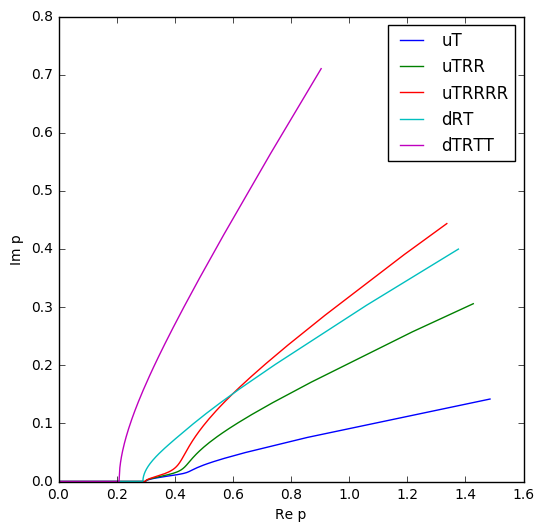

In [48]:
#Plot p-plane ray paths
fig, ax = plt.subplots(1, 1, figsize = (6,6))
ax.plot(p_uT.real,p_uT.imag,p_uTRR.real,p_uTRR.imag,p_uTRRRR.real,p_uTRRRR.imag,p_dRT.real,p_dRT.imag,p_dTRTT.real,p_dTRTT.imag)
ax.set_xlabel("Re p")
ax.set_ylabel("Im p")
ax.legend(("uT","uTRR","uTRRRR","dRT","dTRTT"))
# ax.set_xlim(right=1)
# ax.set_ylim(top=.3)

In [49]:
#Sum imaginary parts for SH1 and SH2
SH_sum = np.array(SH_uT(t_uT,p_uT,B_arr,rho,dt))
SH_sum += np.array(SH_uTRR(t_uTRR,p_uTRR,B_arr,rho,dt))
SH_sum += np.array(SH_uTRRRR(t_uTRRRR,p_uTRRRR,B_arr,rho,dt))
SH_sum += np.array(SH_dRT(t_dRT,p_dRT,B_arr,rho,dt))
SH_sum += np.array(SH_dTRTT(t_dTRTT,p_dTRTT,B_arr,rho,dt))
# SH1,SH2 = SH_sum

#Apply radiation pattern and source time function
t = np.arange(dt,tmax,dt)
A4,A5 = radiationPattern(azimuth,strike,dip,rake)
M0=scaleMoment(M0,x,B_arr[1],rho[1])
uSH = synth_sourcetime(A4,A5,M0,Vt(t,x,SH_sum[0,:]),Vt(t,x,SH_sum[1,:]),risetime,dt,rho) #njl

(0.0, 8000)

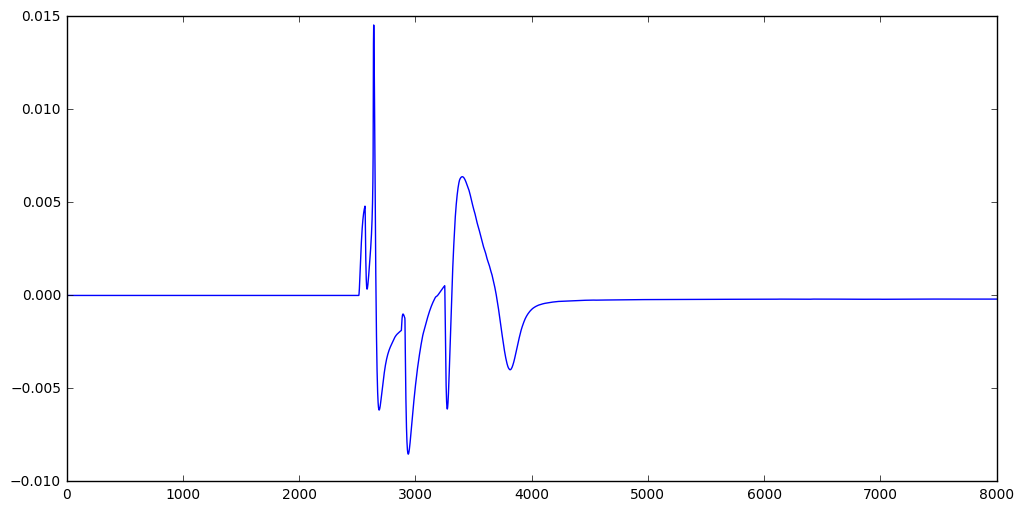

In [50]:
fig, ax = plt.subplots(1, 1, figsize = (12,6))
ax.plot(uSH)
ax.set_xlim(right=8000)

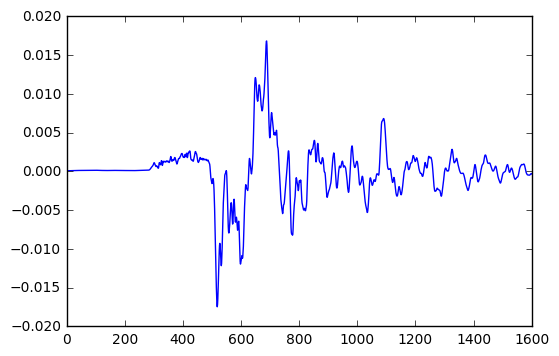

In [51]:
d=obspy.read('alumdata')
plt.plot(d[0])